## Packages and Assets

In [1]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


In [2]:
model = keras.models.load_model('../../assets/lstm_assets/lstm_model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           3110400   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,400,356
Trainable params: 289,956
Non-tr

In [3]:
# Load the tokenizer from the file
with open('../../assets/lstm_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Functions

In [4]:
def transformDocument(df, column_name, language):
    stop_words = usingStopwords(language)
    # 1. Aplicar preprocessamento nos títulos e textos completos
    if language == 'pt':
        # Substituir símbolos importantes
        df[column_name] = df[column_name].map(lambda s: s.replace('-feira', ''))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'mais '))
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'menos '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' por cento'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    elif language == 'en':
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'less'))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'plus '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' percent'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    else:
        pass

    df[column_name] = df[column_name].map(lambda s: s.replace('R$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('U$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('US$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df[column_name] = df[column_name].map(lambda s:
                                              normalizarString(s))

    # Remover Pontuações
    # Remover Pontuações
    df[column_name] = df[column_name].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis
    df[column_name] = df[column_name].map(lambda s: removeEmojis(s))

    # Quebras de Linha desnecessárias
    df[column_name] = df[column_name].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df[column_name] = df[column_name].map(lambda s: s.replace('\"', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('“', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('”', ''))

    # Remover valores
    df[column_name] = df[column_name].map(lambda s: removeValores(s))

    # Espaços desnecessários
    df[column_name] = df[column_name].map(lambda s: s.strip())
    return df

def removeEmojis(sentence):
    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def removeValores(sentence):
    new_sentece = ''

    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)

    return new_sentece

def usingStopwords(language):
    stop_words = []

    nltk.download('stopwords')

    if language == 'pt':
        stop_words = nltk.corpus.stopwords.words('portuguese')
    elif language == 'en':
        stop_words = nltk.corpus.stopwords.words('english')

    return stop_words

def removeStopwords(text, stop_words):
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(word)

    text = ' '.join(tokens)
    return text

def normalizarString(text):
    """
    Função para retirar acentuações e converter para minúscula
    :param text:
    :return text_normalizado
    """
    import unicodedata

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text.lower())

## Loading test data

In [5]:
test_raw = pd.read_csv('../../assets/data/splits/test/raw.csv')
test_raw

,title,tags,link,label
0,Agenda do Dia: Vale; Embraer; Gafisa; Braskem;...,"['agenda do dia', 'Santos Brasil (STBP3)', 'Va...",https://www.suno.com.br/noticias/agenda-do-dia...,2
1,Etanol confirma liquidação nas usinas antes do...,"['Agronegócio', 'Cana-de-Açúcar', 'Etanol', 'G...",https://www.moneytimes.com.br/etanol-confirma-...,1
2,"IRB Brasil chega a cair 15,17% após carta da S...","['IRB Brasil', 'IRBR3']",https://www.sunoresearch.com.br/noticias/irb-b...,0
3,"Em recuperação judicial, Livraria Saraiva fech...","['recuperação judicial', 'Saraiva Livrarias']",https://www.sunoresearch.com.br/noticias/livra...,0
4,"Dólar encerra em queda de 1,1%, cotado em R$ 5,08","['Banco da Inglaterra', 'coronavírus', 'dólar'...",https://www.sunoresearch.com.br/noticias/dolar...,0
...,...,...,...,...
1797,Facebook notifica brasileiros que tiveram dado...,"['Facebook', 'Investidores']",https://www.sunoresearch.com.br/noticias/faceb...,0
1798,Tesouro Direto: confira os preços desta sexta-...,"['Tesouro Direto', 'Tesouro Nacional']",https://www.sunoresearch.com.br/noticias/tesou...,0
1799,Petrobras convoca assembleia para 27 de agosto...,"['Empresas', 'Petrobras', 'Reuters', 'Tesouro ...",https://www.moneytimes.com.br/petrobras-convoc...,1
1800,"Itaú (ITUB4), Bradesco (BBDC4): Inadimplência ...","['B3 (B3SA3)', 'B3 (B3SA3)', 'Banco do Brasil ...",https://www.suno.com.br/noticias/inadimplencia...,3


In [6]:
test_preprocessed = transformDocument(test_raw, 'title', 'pt')

X_test = test_preprocessed.title
y_test = test_preprocessed.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guilherme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[ 118,   53,    5, ...,    0,    0,    0],
       [ 153,  258, 2909, ..., 1934,   40,    0],
       [ 167,   13,  291, ..., 3789,   83,    0],
       ...,
       [   3, 1306,  404, ...,    0,    0,    0],
       [   7,   42,   77, ..., 2368,  459,   59],
       [8949, 2354,  313, ...,    0,    0,    0]])

### Functions

In [7]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [8]:
index_word = index2word(word_index)

In [9]:
pred_prob = model.predict(test_padded)

57/57 [==============================] - 2s 6ms/step


In [10]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [11]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[118, 53, 5, 330, 1393, 136, 493, 13]",agenda dia vale embraer gafisa braskem santos ...,"[agenda, dia, vale, embraer, gafisa, braskem, ...",2,2
1,"[153, 258, 2909, 752, 323, 2, 1404, 274, 1934,...",etanol confirma liquidacao usinas antes <NUM> ...,"[etanol, confirma, liquidacao, usinas, antes, ...",1,1
2,"[167, 13, 291, 758, 2, 4, 14, 2044, 3789, 83]",irb brasil chega cair <NUM> cento apos carta s...,"[irb, brasil, chega, cair, num, cento, apos, c...",0,0
3,"[316, 174, 427, 4531, 1843, 36, 262, 315]",em recuperacao judicial livraria saraiva fecha...,"[em, recuperacao, judicial, livraria, saraiva,...",2,0
4,"[28, 103, 12, 2, 4, 400, 2]",dolar encerra queda <NUM> cento cotado <NUM>,"[dolar, encerra, queda, num, cento, cotado, num]",0,0
...,...,...,...,...,...
1797,"[712, 2280, 361, 445, 1]",facebook notifica brasileiros dados roubados,"[facebook, notifica, brasileiros, dados, <OOV>]",0,0
1798,"[101, 105, 82, 58, 615, 182]",tesouro direto confira precos desta sexta,"[tesouro, direto, confira, precos, desta, sexta]",0,0
1799,"[3, 1306, 404, 2, 231, 2793, 1668, 110]",petrobras convoca assembleia <NUM> agosto eleg...,"[petrobras, convoca, assembleia, num, agosto, ...",1,1
1800,"[7, 42, 77, 397, 1380, 755, 17, 109, 2368, 459...",itau itub4 bradesco bbdc4 inadimplencia pressa...,"[itau, itub4, bradesco, bbdc4, inadimplencia, ...",3,3


### Metrics

In [12]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       609
           1       0.86      0.79      0.83       589
           2       0.87      0.80      0.83       379
           3       0.94      0.52      0.66       225

    accuracy                           0.80      1802
   macro avg       0.84      0.76      0.78      1802
weighted avg       0.82      0.80      0.80      1802

Confusion Matrix


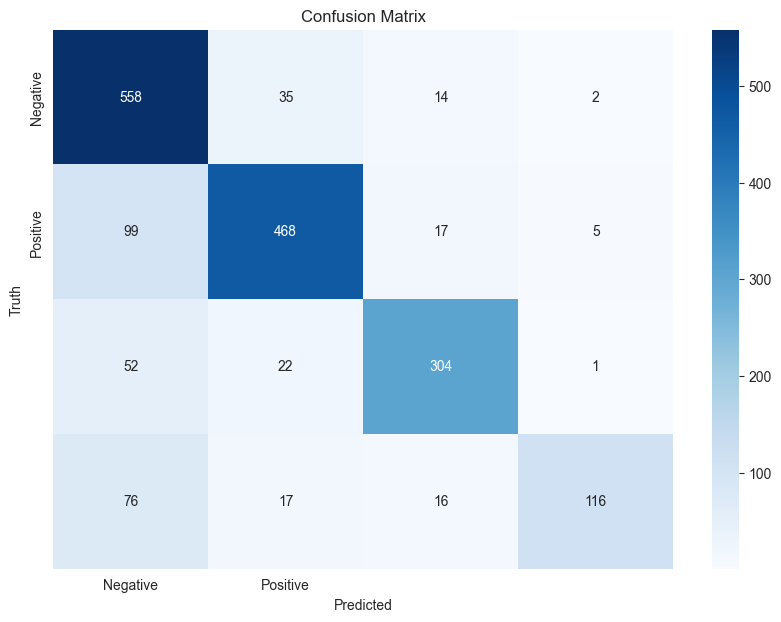

In [13]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)